In [8]:
import numpy as np
import pandas as pd
from statistics import mean, stdev

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO,TraceGraph_ELBO, MCMC, NUTS, HMC
from pyro.poutine.runtime import effectful

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn as sns
import time 

from scipy import stats
import graphviz
from tqdm import tqdm

import yaml



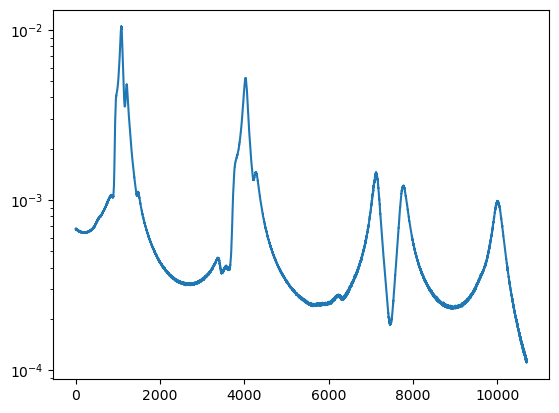

In [449]:
import scipy.io as sio
data = sio.loadmat("../Data/laser/references/scanFlatBeamCornerMiddleLimit.mat")
ref = sio.loadmat("../Data/laser/references/FlatBeamRefCenter.mat")

mobility = abs(data["y_FRF_vel"][1]/(ref["y_FRF_acc"][0]*0.2))
freq = data["x_FRF_disp"][0]
plt.plot(mobility[2000:])
plt.yscale("log")
mobility = mobility[2000:]
freq = freq[2000:]

<AxesSubplot:ylabel='Density'>

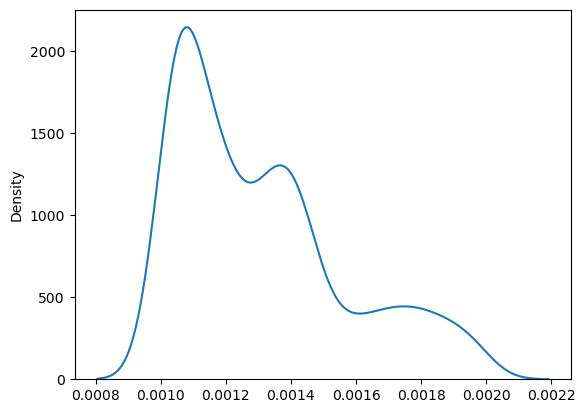

In [445]:

sns.kdeplot(mobility[np.logical_and(mobility>0.001, mobility<0.002)], label="mobility > 0.2")

<AxesSubplot:ylabel='Density'>

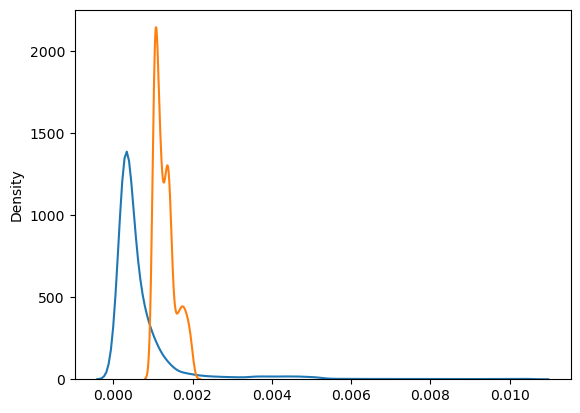

In [446]:

sns.kdeplot(mobility, label="mobility all values")
goal = mobility[np.logical_and(mobility>2, mobility<4)]
goal = mobility[np.logical_and(mobility>2, mobility<7)]
goal = mobility[np.logical_and(mobility>0.001, mobility<0.002)]
sns.kdeplot(goal, label="mobility > 0.2")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.001307066239900333
0.00026009620231312824


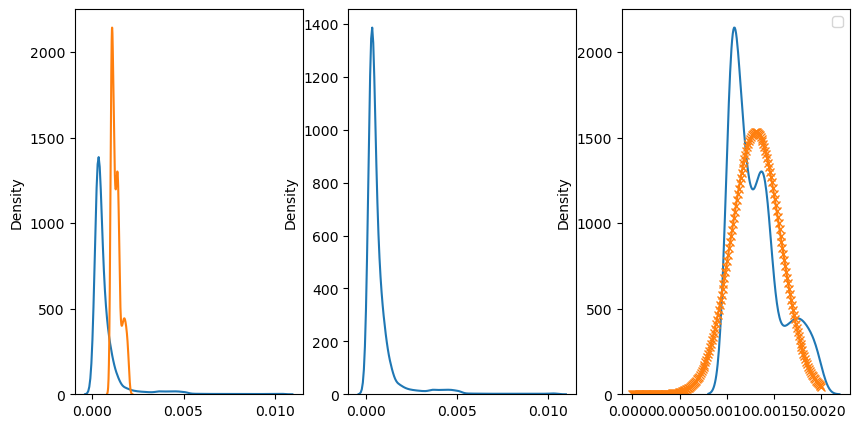

In [453]:
fig, axes = plt.subplots(figsize=(10,5), ncols=3, nrows=1)
goal = mobility[np.logical_and(mobility>0.001, mobility<0.002)]
goalFreq = freq[np.logical_and(mobility>0.001, mobility<0.002)]
sns.kdeplot(mobility, label="mobility all values", ax=axes[0])
sns.kdeplot(goal, label="mobility > 0.2", ax=axes[0])
sns.kdeplot(mobility, ax=axes[1])
meanDist = mean(goal)
stdDist = stdev(goal)
print(meanDist)
print(stdDist)
x = np.linspace(0.000,0.002, 200)
sns.kdeplot(goal, ax=axes[2])
axes[2].plot(x, stats.norm.pdf(x, meanDist, stdDist), "x-")
plt.legend()

In [436]:
goal

array([0.10019517, 0.10745526, 0.11689263, 0.12965065, 0.14806599,
       0.17791722, 0.23008304, 0.3231435 , 0.47260758, 0.70074078,
       1.05820343, 1.31904317, 0.96469282, 0.63145103, 0.44586765,
       0.33834996, 0.2703178 , 0.22256686, 0.18937386, 0.16386643,
       0.14409694, 0.12834349, 0.11559804, 0.10493742])

Text(0.5, 1.0, 'Samples used for training')

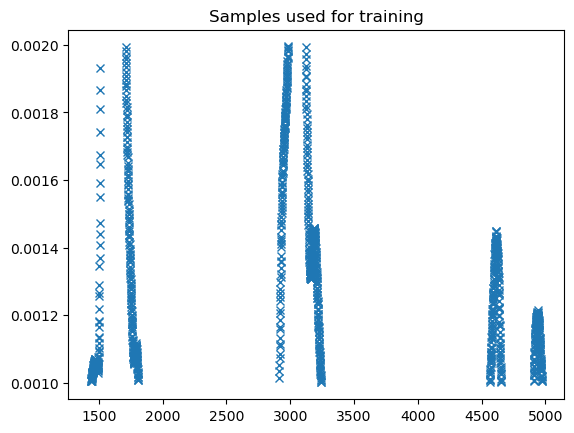

In [454]:
plt.plot(goalFreq, goal, "x")
plt.title("Samples used for training")
#plt.text(1000, 6,"number of points: "+str(len(goal)))

In [455]:
E_values = []
rho_values = []
eta_values = []

def normalization(rho, eta, E):
    E_theo=8e9
    E_var_init = 2.5e8
    rho_theo=1240.0 
    rho_var_init = 100
    eta_mean = 0.07# 2.2 previous
    eta_var_init = 0.1
    
    rho_norm = rho*0.1*rho_var_init + rho_theo
    eta_norm = eta*0.1*eta_var_init + eta_mean
    E_norm = E*0.1*E_var_init + E_theo

    return rho_norm, eta_norm, E_norm

def model(x, y_obs):
    # Density definition
    rho_mean = pyro.param("rho_mean", torch.tensor(0.))
    rho_std = pyro.param("rho_std", torch.tensor(.1), constraint=constraints.positive)
    rho = pyro.sample("rho", dist.Normal(rho_mean, rho_std))
    # Damping loss factor definition
    eta_mean = pyro.param("eta_mean", torch.tensor(0.))
    eta_std = pyro.param("eta_std", torch.tensor(.1), constraint=constraints.positive)
    eta = pyro.sample("eta", dist.Normal(eta_mean, eta_std))
    # Young's modulus definition
    E_mean = pyro.param("E_mean", torch.tensor(0.))
    E_std = pyro.param("E_std", torch.tensor(.1), constraint=constraints.positive)
    E = pyro.sample("E", dist.Normal(E_mean, E_std))
    
    rho, eta, E = normalization(rho, eta, E)
    #rho, eta, E = normalization(rho*rho_std+rho_mean, eta*eta_std+eta_mean, E*E_std+E_mean)
    E_values.append(E)
    rho_values.append(rho)
    eta_values.append(eta)

    y_values = mobilityFuncModel(E, rho, eta, x)
    with pyro.plate("data", len(y_obs)):
        y = pyro.sample("y", dist.Normal(y_values, 0.00026009), obs=y_obs)
        #y = pyro.sample("y", dist.Beta(paramsBeta[0], paramsBeta[1]), obs=y_obs)
    return y

def guide(x, y_obs):
    # Density guide
    rho_mean_q = pyro.param("rho_mean_guide", torch.tensor(0.))
    rho_std_q = pyro.param("rho_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("rho", dist.Normal(rho_mean_q, rho_std_q))
    # Damping loss factor guide
    eta_mean_q = pyro.param("eta_mean_guide", torch.tensor(0.))
    eta_std_q = pyro.param("eta_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("eta", dist.Normal(eta_mean_q, eta_std_q))

    # Damping loss factor guide
    E_mean_q = pyro.param("E_mean_guide", torch.tensor(0.))
    E_std_q = pyro.param("E_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("E", dist.Normal(E_mean_q, E_std_q))

def mobilityFuncModel(E_dist, rho_dist, eta_dist, freq, E_theo=10e10, rho_theo=8976, eta_theo=0.007):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12

    E = E_dist
    rho = rho_dist
    eta = eta_dist
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*torch.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = torch.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = torch.cos(complex_kl)*torch.cosh(complex_kl) + 1
    D_l = torch.cos(complex_kl)*torch.sinh(complex_kl) + torch.sin(complex_kl)*torch.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*torch.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)


In [456]:
freqTrain = torch.tensor(goalFreq)
data = torch.tensor(goal)

pyro.clear_param_store()
adam_params = {
    "lr": .01, #0.001,
    "betas": (0.96, 0.999),
    "clip_norm": 20.0,
    "lrd": 0.99996,
    "weight_decay": 2.0}
optim = pyro.optim.ClippedAdam(adam_params)
svi = SVI(model, guide, optim, loss=TraceGraph_ELBO())

n_steps = 2000
losses = np.zeros(n_steps)
for step in tqdm(range(n_steps)):   
    loss = svi.step(freqTrain, data)
    losses[step] = (loss)

100%|██████████| 2000/2000 [00:05<00:00, 386.98it/s]


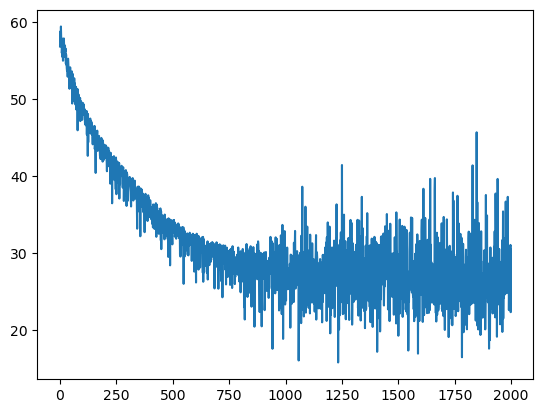

In [430]:
plt.plot(losses)

In [433]:

E_est = pyro.param("E_mean_guide").item()
eta_est = pyro.param("eta_mean_guide").item()
rho_est = pyro.param("rho_mean_guide").item()
E_std = pyro.param("E_std_guide").item()
eta_std = pyro.param("eta_std_guide").item()
rho_std = pyro.param("rho_std_guide").item()       
print(E_est)  
print(E_std)
rho, eta, E = normalization(rho_est, eta_est, E_est)
y_est = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(goalFreq))
y_total = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(freq))
y_init = mobilityFuncModel(torch.tensor(8e9), torch.tensor(1240.), torch.tensor(0.07), torch.tensor(freq))


-0.046143755316734314
0.9839668273925781


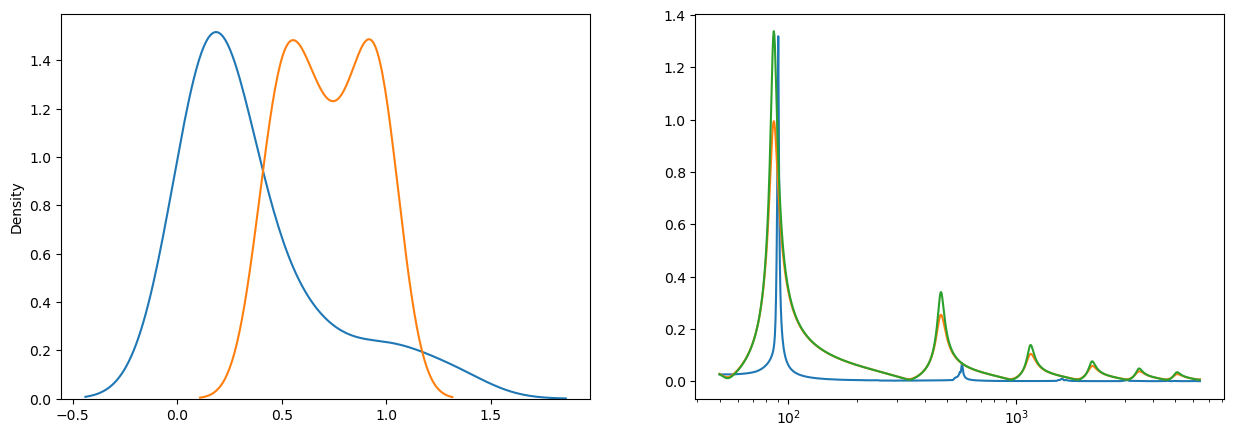

In [435]:
fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
sns.kdeplot(goal, ax=axes[0], label="True posterior")
sns.kdeplot(y_est, ax=axes[0], label="estimated posterior")
axes[1].plot(freq, mobility)
axes[1].plot(freq, y_total)
axes[1].plot(freq, y_init)
axes[1].set_xscale("log")

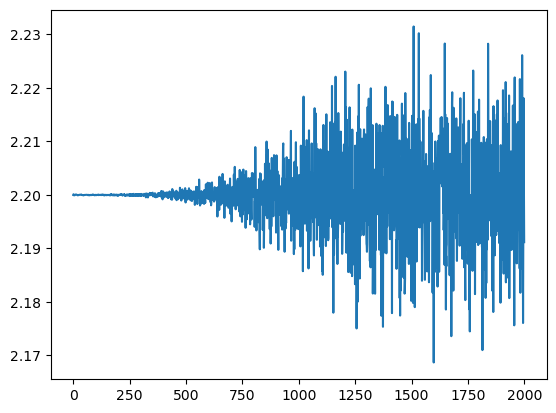

In [350]:
E_val = np.zeros(len(E_values))
eta_val = np.zeros(len(eta_values))
for i in range(len(E_values)):
    E_val[i] = E_values[i].detach().numpy()
    eta_val[i] = eta_values[i].detach().numpy()
plt.plot(eta_val)

In [220]:
B = (((0.02636*0.0035)**3)/12)*3.6e12
massUnit = 0.192*0.2

In [221]:
massUnit

0.038400000000000004

In [223]:
np.sqrt(B/massUnit)/(0.2**2)

61.92345779171905

In [416]:

beam = {"length": 0.2,
    "width": 0.02636,
    "thickness": 0.0035,
    "density" : 1240,
    "E" : 10e9,
    "mass": 0.0192
    
    }
beam["massPerUnit"] = beam["mass"] / beam["length"]
beam["I"] = beam["width"]*beam["thickness"]**3/12

beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
beam["I"] = (beam["width"] * beam["thickness"])**3/12
beam["B"] =  beam["E"]*beam["I"]

In [417]:
f = (3.561/beam["length"])* np.sqrt(beam["B"]/beam["massPerUnit"])
print(f)

1.4700628879754107


In [234]:
beam["mass"]*0.1/beam["volume"] 

1040.5376110990678

In [426]:

y_init = mobilityFuncModel(torch.tensor(8e9), torch.tensor(1240.), torch.tensor(0.07), torch.tensor(freq))

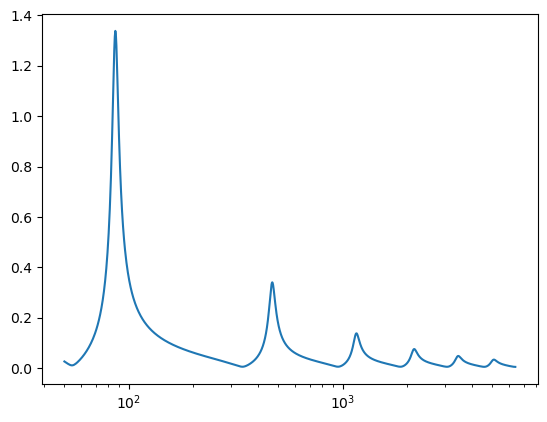

In [427]:
plt.plot(freq, y_init)
plt.xscale("log")

In [324]:

ref[0]


array([-141.01112366+169.2558136j , -140.03367615+176.41775513j,
       -140.1839447 +184.6204834j , ...,  177.59199524-233.67155457j,
        180.4526825 -231.7935791j ,  174.47616577-225.80818176j])